## Example Notebook

Examples used for EUFN Talk.


In [3]:
%load_ext autoreload
%autoreload 2


from fibsem import utils, acquire, movement
from fibsem.structures import BeamType, Point, FibsemImage, FibsemStagePosition

import numpy as np
import matplotlib.pyplot as plt
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")


2023-05-29 09:49:00,632 — root — INFO — connect_to_microscope:2224 — Microscope client connecting to [localhost:8300]
2023-05-29 09:49:00,636 — root — INFO — connect_to_microscope:2226 — Microscope client connected to [localhost:8300]
2023-05-29 09:49:01,467 — root — INFO — connect_to_microscope:2232 — Microscope client connected to model S8202G with serial number 42 and software version TESCAN Essence Version 1.2.1.0, build 5762.
2023-05-29 09:49:01,468 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-05-29-09-49-00AM


### Imaging

Take an image with both beams at different hfws, and plot.


In [5]:
settings.image.beam_type = BeamType.ION
settings.image.autocontrast = False
settings.image.save = True
settings.image.save_path = os.path.join(os.getcwd(), "demo", "imaging")
os.makedirs(settings.image.save_path, exist_ok=True)


settings.image.hfw = 80e-6

hfws = [80e-6, 150e-6, 400e-6, 900e-6]
for i, hfw in enumerate(hfws):

    settings.image.hfw = hfw
    settings.image.label = f"hfws_{i:02d}"

    ib_image = acquire.new_image(microscope, settings.image)


2023-05-29 09:49:01,634 — root — INFO — acquire_image:2244 — acquiring new ION image.
2023-05-29 09:49:04,536 — root — INFO — acquire_image:2244 — acquiring new ION image.
2023-05-29 09:49:07,455 — root — INFO — acquire_image:2244 — acquiring new ION image.
2023-05-29 09:49:10,380 — root — INFO — acquire_image:2244 — acquiring new ION image.


### Loading Images, Reading Metadata

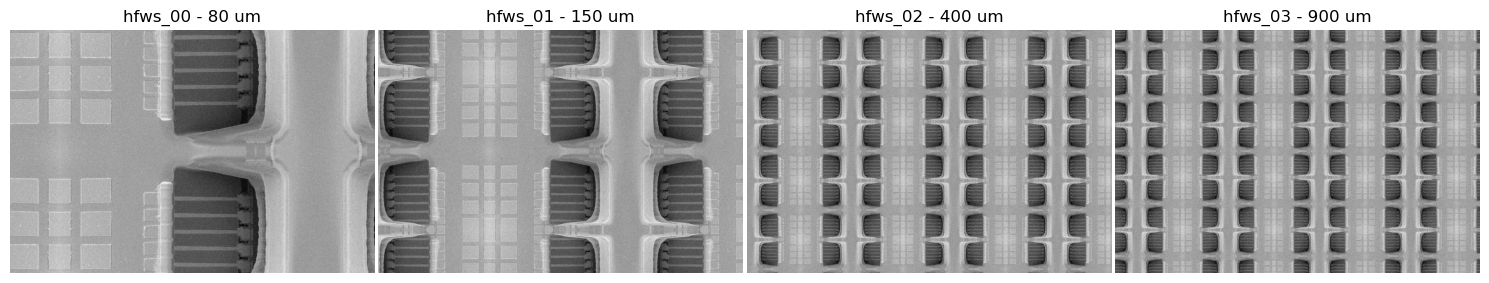

In [6]:
# loading images

import glob
from fibsem.structures import FibsemImage

filenames = sorted(glob.glob(os.path.join(settings.image.save_path, "hfws*.tif")))

# plot wiht subplot
fig, axes = plt.subplots(1, len(filenames), figsize=(15, 5))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)]
    ax.imshow(image.data, cmap="gray")
    ax.set_title(f"{image.metadata.image_settings.label} - {image.metadata.image_settings.hfw*1e6:.0f} um")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "hfws.png"), dpi=300)

plt.show()
    


### Stage Movement

Basic stage movement, and plotting.

2023-05-29 09:49:16,168 — root — INFO — acquire_image:2244 — acquiring new ELECTRON image.
2023-05-29 09:49:18,778 — root — INFO — acquire_image:2244 — acquiring new ION image.
2023-05-29 09:49:21,680 — root — INFO — move_stage_relative:2698 — Moving stage by FibsemStagePosition(x=5e-05, y=None, z=None, r=None, t=None, coordinate_system=None).
2023-05-29 09:49:21,682 — root — INFO — move_stage_absolute:2671 — Moving stage to FibsemStagePosition(x=0.00205, y=0.02, z=0.05999313, r=1.5707963267948966, t=0.0, coordinate_system='RAW').
2023-05-29 09:49:21,921 — root — INFO — acquire_image:2244 — acquiring new ELECTRON image.
2023-05-29 09:49:24,539 — root — INFO — acquire_image:2244 — acquiring new ION image.


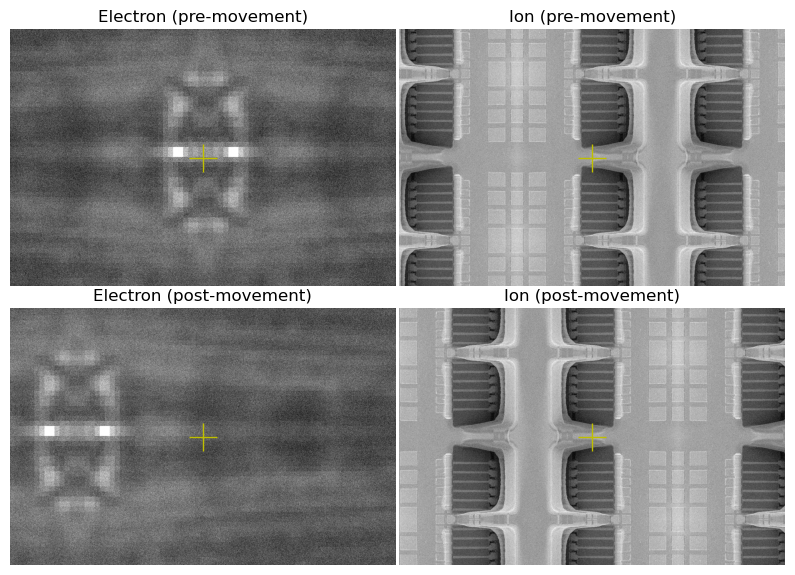

In [7]:
# image settings
settings.image.hfw = 150e-6
settings.image.save = True
settings.image.save_path = os.path.join(os.getcwd(), "demo", "movement")
os.makedirs(settings.image.save_path, exist_ok=True)

# acquire images with both beams
settings.image.label = "pre-movement"
eb_image0, ib_image0 = acquire.take_reference_images(microscope, settings.image)

# move stage by 50um
move_position = FibsemStagePosition(x=50e-6)
microscope.move_stage_relative(move_position)

# acquire images with both beams
settings.image.label = "post-movement"
eb_image1, ib_image1 = acquire.take_reference_images(microscope, settings.image)



# plot images
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes[0][0].imshow(eb_image0.data, cmap="gray")
axes[0][0].set_title("Electron (pre-movement)")
# crosshair, centre, yellow
axes[0][0].plot(eb_image0.data.shape[1]/2, eb_image0.data.shape[0]/2, "y+", ms=20)
axes[0][1].imshow(ib_image0.data, cmap="gray")
axes[0][1].set_title("Ion (pre-movement)")
axes[0][1].plot(ib_image0.data.shape[1]/2, ib_image0.data.shape[0]/2, "y+", ms=20)

axes[1][0].imshow(eb_image1.data, cmap="gray")
axes[1][0].set_title("Electron (post-movement)")
# crosshair, centre, yellow
axes[1][0].plot(eb_image1.data.shape[1]/2, eb_image1.data.shape[0]/2, "y+", ms=20)
axes[1][1].imshow(ib_image1.data, cmap="gray")
axes[1][1].set_title("Ion (post-movement)")
axes[1][1].plot(ib_image1.data.shape[1]/2, ib_image1.data.shape[0]/2, "y+", ms=20)

# axes off
for ax in axes.flatten():
    ax.axis("off")

# wspace
plt.subplots_adjust(hspace=0.07, wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "movement.png"), dpi=300)

plt.show()


## Scripting Examples

### Rotation Example

Rotate the stage, and take an image at each step (15deg).

In [15]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")

# image settings
settings.image.save = True 
settings.image.save_path = os.path.join(os.getcwd(), "demo", "rotation")
os.makedirs(settings.image.save_path, exist_ok=True)

rot = 30    # rotation angle
for i in range(360//rot):
    
    # move stage relative
    microscope.move_stage_relative(FibsemStagePosition(r=np.deg2rad(rot)))

    # acquire images with both beams
    settings.image.label = f"rot_{i:03d}"
    eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

2023-05-29 09:50:32,668 — root — INFO — connect_to_microscope:2224 — Microscope client connecting to [localhost:8300]
2023-05-29 09:50:32,672 — root — INFO — connect_to_microscope:2226 — Microscope client connected to [localhost:8300]
2023-05-29 09:50:33,470 — root — INFO — connect_to_microscope:2232 — Microscope client connected to model S8202G with serial number 42 and software version TESCAN Essence Version 1.2.1.0, build 5762.
2023-05-29 09:50:33,470 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-05-29-09-50-32AM
2023-05-29 09:50:33,473 — root — INFO — move_stage_relative:2698 — Moving stage by FibsemStagePosition(x=None, y=None, z=None, r=0.5235987755982988, t=None, coordinate_system=None).
2023-05-29 09:50:33,475 — root — INFO — move_stage_absolute:2671 — Moving stage to FibsemStagePosition(x=0.0020499999999999997, y=0.02, z=0.05999313, r=2.0943951023931953, t=0.0, coordinate_system='RAW').
2023-05-29 09:50:33,971 — root — INFO — autocontrast:2515 — Run

## Tiling Example

Take a 3x3 tile scan with the ION beam and plot.

In [16]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")

# image settings
settings.image.hfw = 80e-6
settings.image.resolution = [1024, 1024]
settings.image.beam_type = BeamType.ION
settings.image.save = True 
settings.image.save_path = os.path.join(os.getcwd(), "demo", "tile")
os.makedirs(settings.image.save_path, exist_ok=True)

# tile settings
dx, dy = settings.image.hfw, settings.image.hfw
nrows, ncols = 3, 3

# tile
initial_position = microscope.get_stage_position()
for i in range(nrows):

    # restore position
    microscope.move_stage_absolute(initial_position)
    # stable movement dy
    microscope.stable_move(dx=0, dy=dy*i, settings=settings, beam_type=BeamType.ION)

    for j in range(ncols):
    
        # stable movement dx
        microscope.stable_move(dx=dx*j, dy=0, settings=settings, beam_type=BeamType.ION)
        # acquire images with both beams
        settings.image.label = f"tile_{i:03d}_{j:03d}"
        ib_image = acquire.new_image(microscope, settings.image)

2023-05-29 09:53:13,726 — root — INFO — connect_to_microscope:2224 — Microscope client connecting to [localhost:8300]
2023-05-29 09:53:13,730 — root — INFO — connect_to_microscope:2226 — Microscope client connected to [localhost:8300]
2023-05-29 09:53:14,529 — root — INFO — connect_to_microscope:2232 — Microscope client connected to model S8202G with serial number 42 and software version TESCAN Essence Version 1.2.1.0, build 5762.
2023-05-29 09:53:14,530 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-05-29-09-53-13AM
2023-05-29 09:53:14,534 — root — INFO — move_stage_absolute:2671 — Moving stage to FibsemStagePosition(x=0.0020499999999999997, y=0.02, z=0.05999313, r=1.5707963267948966, t=0.0, coordinate_system='RAW').
Stage tilt: 0.0, corrected pretilt: -0.6279694648675597, y_move: -0.0 z_move: 0.0
2023-05-29 09:53:14,772 — root — INFO — stable_move:2757 — moving stage (ION): FibsemStagePosition(x=0, y=0.0, z=0.0, r=0, t=0, coordinate_system=None)
2023-05-29 

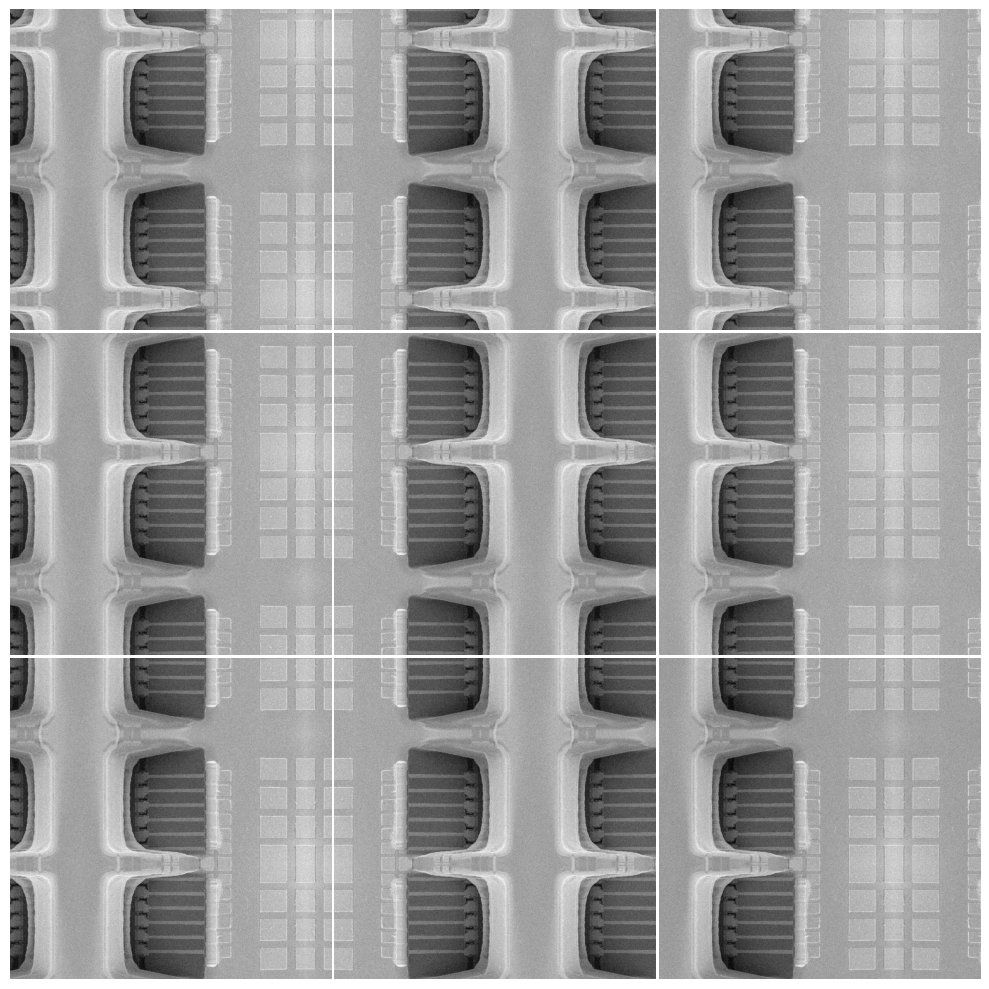

In [17]:
# plot tiles
import glob
filenames = sorted(glob.glob(os.path.join(settings.image.save_path, "tile*.tif")))


fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)//ncols][filenames.index(fname)%ncols]
    ax.imshow(image.data, cmap="gray")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(hspace=0.01,wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "tiles.png"), dpi=300)

plt.show()

## Serialisation

Writing / Reading structures to disk

In [18]:
from fibsem.structures import MicroscopeState
os.makedirs("demo/state", exist_ok=True)

# get state
print("\nCurrent microscope state:")
state = microscope.get_current_microscope_state()

# save to yaml
print("\nSerialise microscope state")
state_dict = state.__to_dict__()
utils.save_yaml("demo/state/state.yaml", state_dict)

# load from yaml
print("\nDeserialise microscope state")
state_dict = utils.load_yaml("demo/state/state.yaml")
state = MicroscopeState.__from_dict__(state_dict)


Current microscope state:

Serialise microscope state

Deserialise microscope state
